In [1]:
import librosa
import numpy as np

#### Load and segments the audio files 

In [2]:
SR  = 22050
DUR = 4

In [3]:
def segment_audio(audio):
    step   = SR * DUR
    niters = len(audio) // step
    segments = []
    for i in range(0, niters):
        ixs = i * step
        ixe = (i + 1) * step
        segments.append(audio[ixs:ixe])
    return segments

In [4]:
import glob
segments = []
for wavfile in glob.iglob("./simon_wav/*.wav"):
    y, _ = librosa.load(wavfile, mono=True, sr=SR)
    y = y / np.amax(np.abs(y))
    segments_ = segment_audio(y)
    
    assert all([len(s) for s in segments_])
    segments += segments_
    print("parsed segment: " + wavfile)
    
print(len(segments))

parsed segment: ./simon_wav/US_DJH_Drum_118_bounds_KICK.wav
parsed segment: ./simon_wav/US_DJH_Key_118_absent_Abm.wav
parsed segment: ./simon_wav/US_DJH_Key_120_earl_Cm.wav
parsed segment: ./simon_wav/US_DJH_Key_120_merch_Dm.wav
parsed segment: ./simon_wav/US_DJH_Key_120_anti_F#.wav
parsed segment: ./simon_wav/US_DJH_Key_shine_Eb.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_earth_KICK.wav
parsed segment: ./simon_wav/US_DJH_Key_118_cuz_Abm.wav
parsed segment: ./simon_wav/US_DJH_Key_oyster_Cm.wav
parsed segment: ./simon_wav/US_DJH_Key_listen_Cm.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_cuz_KICK.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_inc_SNARE.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_call_FULL.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_cuz_FULL.wav
parsed segment: ./simon_wav/US_DJH_Key_120_dego_Bm.wav
parsed segment: ./simon_wav/US_DJH_Drum_118_dont_HATS.wav
parsed segment: ./simon_wav/US_DJH_Synth_118_lightpad_Dm.wav
parsed segment: ./simon_wav/US_DJH_Drum_


#### Extract STFTs from audio segments (4sec) 

In [5]:
import scipy.signal
from scipy.signal.windows import hamming

NFFT        = 1024
OVERLAP     = 512
REFERENCE   = 100.

In [6]:
def normalize_db(S_db, ref):
    return (S_db / ref) * 2 + 1

def inverse_normalize_db(S_n_db, ref):
    return ((S_n_db - 1) * 0.5) * ref

def amp_to_normalized_db(S):
    top_db = None
    S_db   = librosa.power_to_db(S      = S,
                                 ref    = 1.0,
                                 amin   = 1e-08,
                                 top_db = top_db)
    
    S_db = (S_db + 40.) / 40.
    print(S_db.min(), S_db.max())
    return S_db

def normalized_db_to_amp(S_n_db):
    top_db = 80.
    S_db   = inverse_normalize_db(S_n_db = S_n_db,
                                  ref    = top_db)
    S      = librosa.db_to_amplitude(S_db = S_db, 
                                     ref  = REFERENCE)
    return S
    
def normalize_phase(P):
    P_clip = np.clip(P, -np.pi, np.pi)
    P_normalized = P_clip / np.pi
    return P_normalized

def inverse_normalize_phase(P_n):
    P_n_clip = np.clip(P_n, -1, 1)
    P        = P_n_clip * np.pi
    return P

In [7]:
stft_samples = int(np.ceil(DUR * SR / OVERLAP))
max_rows     = int(stft_samples * len(segments)) 
max_cols     = int(NFFT // 2 + 1)

mag_fft_matrix   = np.zeros((max_rows, max_cols)) 
phase_fft_matrix = np.zeros_like(mag_fft_matrix)
print(mag_fft_matrix.shape, phase_fft_matrix.shape)

win = hamming(NFFT)

for i, seg in enumerate(segments):
    stft = librosa.stft(y          = seg, 
                        n_fft      = NFFT, 
                        hop_length = OVERLAP, 
                        window     = hamming)
    
    stft_mag = np.abs(stft) * 2 / np.sum(win)
    S_db_n = amp_to_normalized_db(stft_mag)
    P_n    = normalize_phase(np.angle(stft))
    
    ixs = i * stft_samples
    ixe = (i + 1) * stft_samples
    mag_fft_matrix[ixs:ixe, :]   = S_db_n.T
    phase_fft_matrix[ixs:ixe, :] = P_n.T

(29064, 513) (29064, 513)
-1.0 0.9785055
-0.812435 0.8782484
-0.6557606 0.8888807
-0.78828967 0.85837805
-0.7913973 0.84869784
-0.9342386 0.8542596
-0.74636614 0.8824005
-0.7421497 0.87391967
-0.894215 0.9323727
-1.0 0.95928687
-0.6688913 0.87995815
-0.84062636 0.8815948
-0.97549707 0.8767762
-1.0 0.9360423
-1.0 1.0018392
-1.0 0.8778632
-1.0 0.97964895
-1.0 0.969292
-0.93742406 0.88292444
-0.6029097 0.88267165
-1.0 0.8429077
-0.60894126 0.85674465
-1.0 0.750946
-0.65028226 0.95686084
-1.0 0.9989936
-1.0 0.74935657
-0.9211546 0.90126246
-0.76327837 0.84096205
-0.7988245 0.8290515
-1.0 0.80171144
-0.72975254 0.9141037
-0.84806573 0.9149009
-1.0 0.7850825
-1.0 0.7528159
-0.90647775 0.83249056
-0.7299145 0.8525564
-1.0 0.7711835
-1.0 0.73724514
-0.841469 0.8778285
-1.0 0.74543846
-1.0 0.9255934
-1.0 0.8613653
-0.8648512 0.9236636
-1.0 0.9970974
-1.0 0.7902716
-1.0 0.88955104
-0.77936363 0.85992193
-1.0 0.9892429
-1.0 0.89286536
-0.7790781 0.92221767
-0.87610626 0.9358786
-0.8285116 0.79891

#### Sanity Check 

-1.0 0.9785054922103882


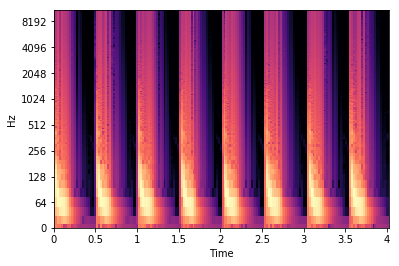

In [9]:
samps = stft_samples
S = mag_fft_matrix[:samps, :].T
print(S.min(), S.max())

S_db_spec = S * 40. - 40
S = librosa.db_to_power(S_db_spec)
S = (S * np.sum(win)) / 2.
#S = magnitude_scaler.inverse_transform(S) #S = inverse_normalize_db(S, 80.)
#print(S.min(), S.max())
#S = librosa.db_to_power(S)
#print(S.shape)

import librosa.display
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db_spec, sr=SR,
                               y_axis='log', x_axis='time', ax=ax)

#S = normalized_db_to_amp(mag_fft_matrix[:samps, :].T)
P = inverse_normalize_phase(phase_fft_matrix[:samps, :].T)
#P = phase_scaler.inverse_transform(phase_fft_matrix[:samps, :]).T
D = S*np.exp(1j*P)

y_ = librosa.istft(stft_matrix = D, 
                   hop_length  = OVERLAP, 
                   window      = hamming)

import IPython.display as ipd
ipd.display(ipd.Audio(y_, rate=SR))

#### Make dataset 

In [10]:
audio_data = {
    "MetaInfo": {
        "SampleRate"  : SR,
        "ClipDuration": DUR,
        "FFTWindow"   : "hamming",
        "Num_fft"     : NFFT,
        "DB_ref"      : 40.,
        "Overlap"     : OVERLAP
    },
    "Data":{
        "NormalizedFFTMagnitudes": mag_fft_matrix,
        "NormalizedFFTPhases"    : phase_fft_matrix
    }
}

import joblib 
joblib.dump(audio_data, "./dance_wav/audio_spectral_data_simon.pkl", compress=3)

['./dance_wav/audio_spectral_data_simon.pkl']